In [1]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, ASTForAudioClassification, AutoConfig
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from tqdm import tqdm
import pickle
import torch.nn.functional as F
import numpy as np
from google.colab import drive

# Google Drive'ı bağla
drive.mount('/content/drive', force_remount=True)

output_dir = "/content/drive/MyDrive/model"  # Google Drive'a kaydetme dizini

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# AudioDataset Sınıfı
class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, processor, target_length=160000):
        self.audio_paths = audio_paths
        self.labels = labels
        self.processor = processor
        self.target_length = target_length

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        file_path = self.audio_paths[idx]
        label = self.labels[idx]
        waveform, sr = torchaudio.load(file_path)
        waveform = waveform.squeeze()

        # Eğer ses uzunluğu target_length'ten küçükse padding ekle
        if waveform.size(0) < self.target_length:
            waveform = F.pad(waveform, (0, self.target_length - waveform.size(0)))
        else:
            waveform = waveform[:self.target_length]

        # Input verisini işleme
        inputs = self.processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)
        return inputs.input_values[0], label

# Veri Yükleme Fonksiyonu
def load_data(base_dir, categories, notes):
    file_paths, labels = [], []
    label_map = {note: idx for idx, note in enumerate(notes)}

    for category in categories:
        for note in notes:
            path = os.path.join(base_dir, category, note)
            if not os.path.exists(path):
                print(f"Warning: {path} does not exist.")
                continue
            files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".wav")]
            file_paths.extend(files)
            labels.extend([label_map[note]] * len(files))
    return file_paths, labels

# Collate Function
def collate_fn(batch):
    inputs = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True)
    return inputs_padded, torch.tensor(labels)

# Modeli eğitirken giriş verisini float32'ye dönüştür
def train_model(train_loader, val_loader, model, processor, epochs=100, output_dir=output_dir):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    loss_fn = torch.nn.CrossEntropyLoss()
    model.to(device)

    global best_accuracy  # Global değişken olarak tanımla
    best_accuracy = 0  # En iyi doğruluk değerini sıfırla
    metrics_history = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_preds, train_targets = [], []
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Veriyi float32'ye dönüştür
                inputs = inputs.to(torch.float32)

                optimizer.zero_grad()
                outputs = model(inputs).logits
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                train_preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())
                train_targets.extend(labels.cpu().numpy())
                pbar.update(1)

        # Eğitim doğruluğu hesapla
        train_accuracy = accuracy_score(train_targets, train_preds)
        print(f"Epoch {epoch + 1}: Train Loss: {total_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        model.eval()
        total_val_loss = 0
        val_targets, val_preds = [], []
        val_probs = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Veriyi float32'ye dönüştür
                inputs = inputs.to(torch.float32)

                outputs = model(inputs).logits
                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                val_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())  # Probabilities for each class

        # Validation metriklerini hesapla
        val_accuracy = accuracy_score(val_targets, val_preds)
        precision = precision_score(val_targets, val_preds, average="weighted", zero_division=1)
        recall = recall_score(val_targets, val_preds, average="weighted", zero_division=1)
        f1 = f1_score(val_targets, val_preds, average="weighted", zero_division=1)

        # ROC ve AUC hesapla
        fpr, tpr, roc_auc = {}, {}, {}
        valid_labels = np.unique(val_targets)  # Geçerli sınıfları al
        for i in valid_labels:
            fpr[i], tpr[i], _ = roc_curve(val_targets, np.array(val_probs)[:, i], pos_label=i)
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Macro ROC AUC hesapla
        all_fpr = np.unique(np.concatenate([fpr[i] for i in valid_labels]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in valid_labels:
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        mean_tpr /= len(valid_labels)
        macro_roc_auc = auc(all_fpr, mean_tpr)

        metrics = {
            "epoch": epoch + 1,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
            "train_loss": total_train_loss,
            "val_loss": total_val_loss,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "roc_auc": roc_auc,
            "macro_roc_auc": macro_roc_auc,
            "fpr": fpr,  # fpr değerlerini kaydet
            "tpr": tpr   # tpr değerlerini kaydet
        }

        metrics_history.append(metrics)
        print(f"Epoch {epoch + 1}: Train Loss: {total_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {total_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Macro ROC AUC: {macro_roc_auc:.4f}")

        save_model_and_metrics(model, epoch, metrics_history, output_dir, val_accuracy)


# Modeli ve metrikleri kaydetme fonksiyonu
def save_model_and_metrics(model, epoch, metrics_history, output_dir, accuracy):
    global best_accuracy  # Fonksiyon içinde global değişkene erişim sağla

    # Klasörlerin olup olmadığını kontrol et ve oluştur
    model_output_dir = os.path.join(output_dir, "ast")
    if not os.path.exists(model_output_dir):
        os.makedirs(model_output_dir)

    # .best.pt sadece en iyi doğrulukla kaydedilecek
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), os.path.join(model_output_dir, "ast_best.pt"))

    # .last.pt her zaman son epoch'la kaydedilecek
    torch.save(model.state_dict(), os.path.join(model_output_dir, "ast_last.pt"))

    # Metrikleri kaydet
    with open(os.path.join(model_output_dir, "metrics.pkl"), "wb") as f:
        pickle.dump(metrics_history, f)


# Google Drive'daki 'model/ast' klasörünü kullanacak şekilde güncelleme
base_dir = "/content/drive/MyDrive/processed"  # MyDrive altında 'processed' klasörünüz var

train_audio_paths, train_labels = load_data(os.path.join(base_dir, "train"), ["akortlu", "akortsuz"], ["Do", "Do#", "Re", "Re#", "Mi", "Fa", "Fa#", "Sol", "Sol#", "La", "La#", "Si"])
val_audio_paths, val_labels = load_data(os.path.join(base_dir, "val"), ["akortlu", "akortsuz"], ["Do", "Do#", "Re", "Re#", "Mi", "Fa", "Fa#", "Sol", "Sol#", "La", "La#", "Si"])

processor = AutoProcessor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
config = AutoConfig.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593", num_labels=12)

# Modeli, verilen yeni yükleme koduyla başlatıyoruz
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593", attn_implementation="sdpa", torch_dtype=torch.float32)

# Model ağırlıklarını float32 olarak yükleyelim
model = model.to(device).float()

train_dataset = AudioDataset(train_audio_paths, train_labels, processor)
val_dataset = AudioDataset(val_audio_paths, val_labels, processor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

train_model(train_loader, val_loader, model, processor)

ValueError: mount failed

Mounted at /content/drive


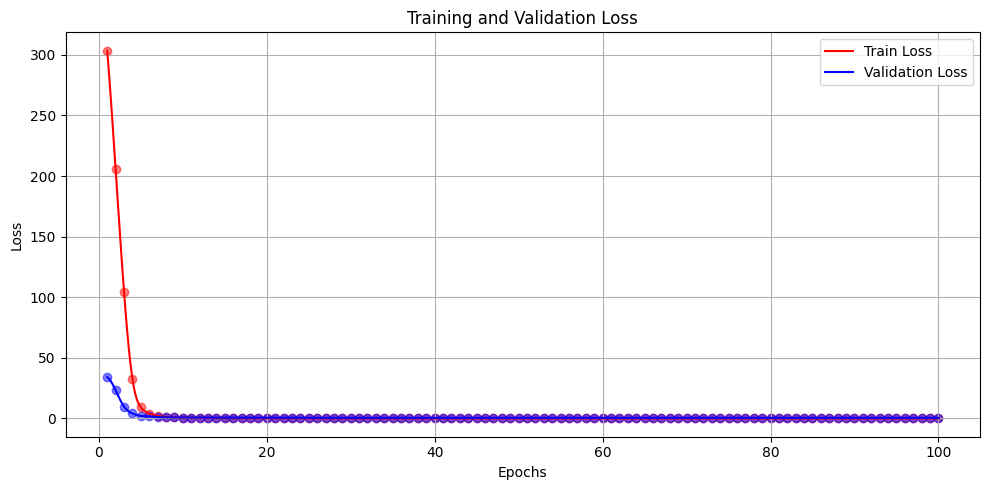

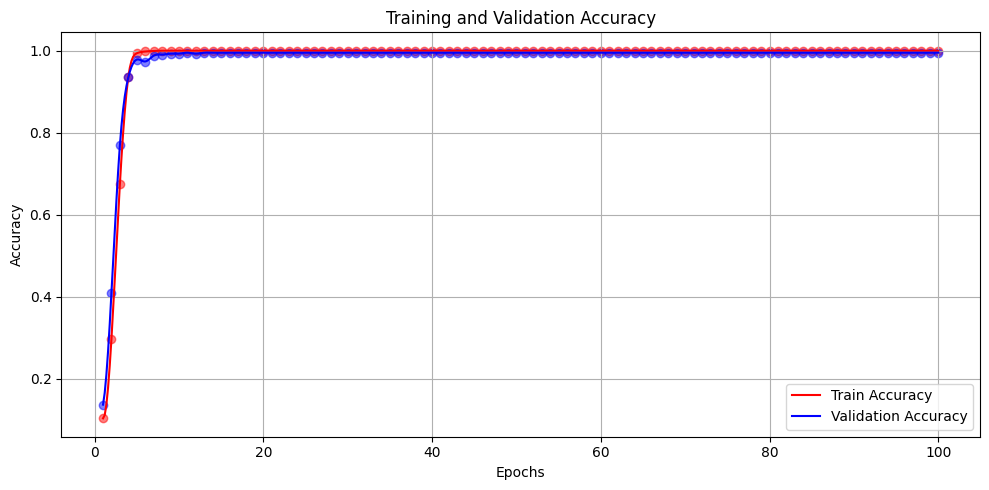

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from google.colab import drive

# Google Drive'ı bağla
drive.mount('/content/drive')

# 'metrics.pkl' dosyasını okuyun
def load_metrics(file_path):
    with open(file_path, "rb") as f:
        metrics_history = pickle.load(f)
    return metrics_history

def plot_metrics_from_file(metrics_history):
    # Epoch numaralarını alın
    epochs = [metrics["epoch"] for metrics in metrics_history]

    # Eğitim ve doğrulama kaybı ve doğruluğunu al
    train_losses = [metrics["train_loss"] for metrics in metrics_history]
    val_losses = [metrics["val_loss"] for metrics in metrics_history]
    train_accuracies = [metrics["train_accuracy"] for metrics in metrics_history]
    val_accuracies = [metrics["val_accuracy"] for metrics in metrics_history]

    # Daha sık aralıklarla epoch değerleri oluşturun
    epochs_new = np.linspace(min(epochs), max(epochs), 500)

    # Kaybı çizmek için spline interpolasyonu
    train_loss_spline = make_interp_spline(epochs, train_losses, k=3)
    train_loss_interpolated = train_loss_spline(epochs_new)

    val_loss_spline = make_interp_spline(epochs, val_losses, k=3)
    val_loss_interpolated = val_loss_spline(epochs_new)

    # Kaybı çiz
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_new, train_loss_interpolated, 'r', label='Train Loss')
    plt.plot(epochs_new, val_loss_interpolated, 'b', label='Validation Loss')
    plt.scatter(epochs, train_losses, color='r', alpha=0.5)
    plt.scatter(epochs, val_losses, color='b', alpha=0.5)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Grafiklerin sıkışıklığını azaltmak için
    plt.show()
    plt.close()

    # Doğruluğu çizmek için spline interpolasyonu
    train_acc_spline = make_interp_spline(epochs, train_accuracies, k=3)
    train_acc_interpolated = train_acc_spline(epochs_new)

    val_acc_spline = make_interp_spline(epochs, val_accuracies, k=3)
    val_acc_interpolated = val_acc_spline(epochs_new)

    # Doğruluğu çiz
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_new, train_acc_interpolated, 'r', label='Train Accuracy')
    plt.plot(epochs_new, val_acc_interpolated, 'b', label='Validation Accuracy')
    plt.scatter(epochs, train_accuracies, color='r', alpha=0.5)
    plt.scatter(epochs, val_accuracies, color='b', alpha=0.5)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Grafiklerin sıkışıklığını azaltmak için
    plt.show()
    plt.close()

# 'metrics.pkl' dosyasının bulunduğu yolu girin
metrics_file_path = "/content/drive/MyDrive/model/ast100/metrics.pkl"

# Metrics verilerini yükleyin
metrics_history = load_metrics(metrics_file_path)

# Grafikleri çizdirin
plot_metrics_from_file(metrics_history)
